# Detect and Group Suspicious HTTP Activity

This detector attempts to identify potentially suspicious HTTP traffic, and then cluster detections into related groups based on common behaviors.

## Algorithms

- #### Initial Filter Heuristic - First pass at filtering out non-suspicious activity based on HOST.
    - Shannon Entropy - Identify how random a HOST is
    - Alexa Top 500k - Identify how common a HOST is
    - Public/Private IP checks - Determine whether or not a client is calling an external IP w/o DNS lookup first

- #### Transformations - Vectorization/Normalization
  - One-hot encoding for categorical fields (string)
  - Normalization accross numeric fields
- #### Clustering - Finding optimal K clusters and Grouping
  - Silhouette Score - measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. This score is used to determine the optimal number of clusters.

  - K-Means Clustering - A method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.


In [1]:
import sys
import json
import hashlib
import warnings
import ipaddress

import pandas
from colorhash import ColorHash
from matplotlib import pyplot
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from sklearn.metrics import silhouette_score
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix

from suspicious_http_detector import utils


## Set up default visualization settings

In [2]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 14.0, 7.0

## Customize Parameters
- ZEEK_HTTP_LOG_PATH
  - The path to the http.log you want to analyze
- SUSPICION_THRESHHOLD (-1...1)
   - \-1 = NOT suspicious
   -   1 = VERY suspicious
- ALEXA_TOP_N (0...1,000,000)
  - Checks hosts against n number of Alexa top-million list. Used with the initial filtering heuristic.

In [3]:
ZEEK_HTTP_LOG_PATH = 'data/mixed_set_1/http_mixed.log'
SUSPICION_THRESHHOLD = .18 # (-1, 1)
ALEXA_TOP_N = utils.get_top_n_alexa('data/lists/top-1m.csv.zip', n=500000)

## Clustering Features
- These are the features we want to used for clustering
- K-Means will use these features and try to find similarities

In [4]:
features = ['method', 'user_agent', 'resp_mime_types', 'host_entropy', 'host_is_ip', 'common_host_domain']

## Build our DataFrame from http.log and add suspicious_score
- Convert Zeek's HTTP Log to a pandas.DataFrame
- Add the following fields
  - host_entropy - A number between 0...5 (where 5 represents an extremely random host string)
  - host_is_ip - True, if no DNS lookup was done
  - host_is_public_ip - True, if no DNS lookup was done and IP is public
  - common_host_domain - True, if the HOST is in ALEXA_TOP_N

In [5]:
# Read in our data and return a dataframe

data_path = ZEEK_HTTP_LOG_PATH
http_transactions_raw = None
with open(data_path, 'r') as data_f:
    http_transactions_raw = data_f.readlines()
if not http_transactions_raw:
    raise Exception(f'File ({data_path}) is empty.')

    
http_transactions =  \
    pandas.DataFrame([json.loads(transaction) for transaction in http_transactions_raw if transaction.strip()])

# Add a few additional fields to help us properly filter out non-suspicious transactions

# Convert mime-types to string
http_transactions.loc[:, 'resp_mime_types'] = http_transactions.resp_mime_types.map(lambda x: ','.join(x) if isinstance(x, list) else '')
# Calculate Shannon Entropy of host
http_transactions.loc[:, 'host_entropy'] = http_transactions.host.map(lambda x: utils.shannon_entropy(x) if isinstance(x, str) else 0)

# Check if host is an IP address
http_transactions.loc[:, 'host_is_ip'] = http_transactions.host.map(lambda x: utils.is_ip_address(x) if isinstance(x, str) else False)

# Check if host is a public IP address
http_transactions.loc[:, 'host_is_public_ip'] = http_transactions.host.map(lambda x: utils.is_ip_address_public(x) if isinstance(x, str) else False)

# check if the host is common
http_transactions.loc[:, 'common_host_domain'] = http_transactions.host.map(lambda x: '.'.join(utils.clean_domain(x)[1:]) in ALEXA_TOP_N if isinstance(x, str) else False)

# calculate the suspicious_score (-1, 1)
http_transactions.loc[:, 'suspicious_score'] = http_transactions.apply(lambda x: utils.calculate_suspicious_score(x), axis=1)


## Filter out any HTTP transactions that do not meet the suspicion threshold

In [6]:
# Filter out 
http_transactions = http_transactions[http_transactions.suspicious_score > SUSPICION_THRESHHOLD]

## Vectorize and normalize remaining transactions

In [7]:
# Convert the DataFrame (features) to matrix (One-hot encoding)

http_transactions_matrix = DataFrameToMatrix().fit_transform(http_transactions[features], normalize=True)
print(f' Matrix Shape: {http_transactions_matrix.shape}')
http_transactions_matrix

Changing column method to category...
Changing column user_agent to category...
Changing column resp_mime_types to category...
Normalizing column host_entropy...
Dropping host_is_ip column...
Dropping common_host_domain column...
 Matrix Shape: (49, 15)


array([[1.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.7572792 , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.8741157 , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.7572792 , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.872775  , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 

## Determine the optimal number of K-Clusters

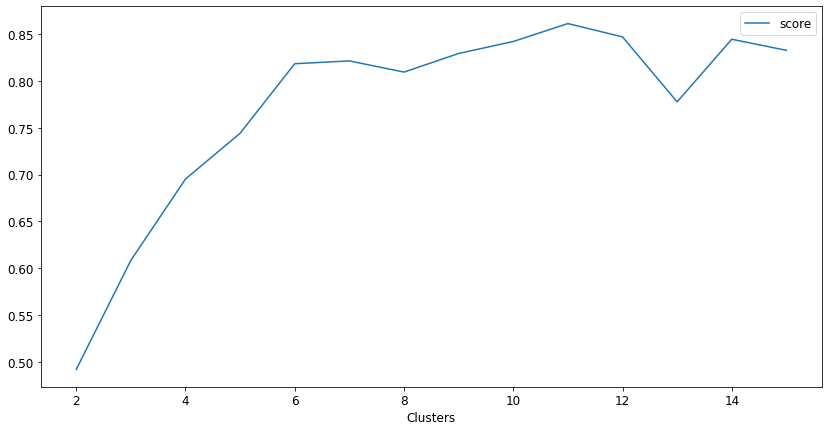

In [19]:
# Determine the optimal number of clusters to use using a Silhouette graph

scores = []
clusters = range(2,16)
with warnings.catch_warnings():
    warnings.filterwarnings('error')
    for K in clusters:
        clusterer = KMeans(n_clusters=K)
        try:
            cluster_labels = clusterer.fit_predict(http_transactions_matrix)
            score = silhouette_score(http_transactions_matrix, cluster_labels)
            scores.append(score)
        except Warning:
            break

try:
    # We can best divide this dataset into "K" number of clusters
    optimal_cluster_value = scores.index(max(scores))
except ValueError:
    optimal_cluster_value = 2
    
# Plot it out
# The typical technique involves finding the X-score (K-hyperparameter) for the highest Y value.
pandas.DataFrame({'Clusters':clusters, 'score':scores}).plot(x='Clusters', y='score')
display(HTML(f'<center><h4>Optimal Cluster Number: {optimal_cluster_value}</h4></center>'))


## Cluster via K-Means using the optimal number of clusters
- Cluster via K-Means
- Use t-distributed stochastic neighbor embedding (TSNE) for visualisation of our high-dimensional data in 2-dimensional space.

In [20]:
kmeans = KMeans(n_clusters=optimal_cluster_value).fit_predict(http_transactions_matrix)

projection = TSNE().fit_transform(http_transactions_matrix)

# Now we can put our ML results back onto our dataframe!
http_transactions['cluster'] = kmeans
http_transactions['x'] = projection[:, 0] # Projection of X
http_transactions['y'] = projection[:, 1] # Projection of Y 

## Plot the results of the TSNE projection. This represents how similar our clusters are to one another.

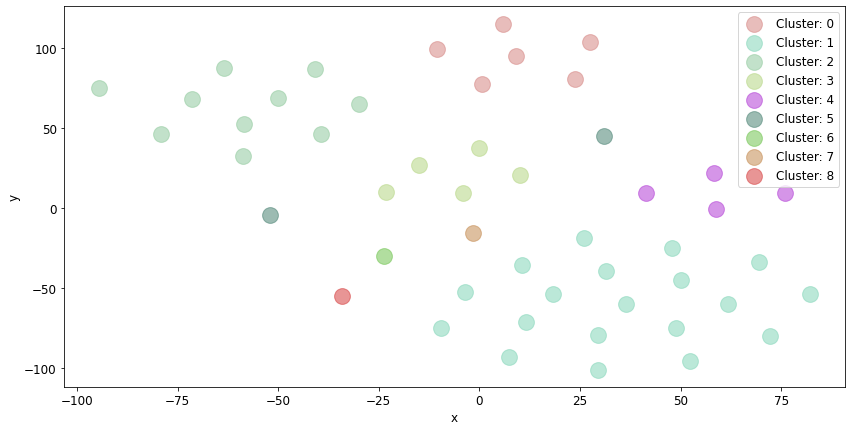

In [21]:
# Now use dataframe group by cluster
cluster_groups = http_transactions.groupby('cluster')

# Plot the Machine Learning results
fig, ax = pyplot.subplots()
for key, group in cluster_groups:
    m = hashlib.md5()
    m.update(str(key * 10000).encode('utf-8'))
    group.plot(ax=ax, kind='scatter', x='x', y='y', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=ColorHash(str(m.hexdigest())).hex)

## Enumerate our detections, grouped by common behaviors.

In [11]:
for key, group in cluster_groups:
    #print(f'Key {key}; Group Size: {len(group)}')
    display(HTML(f'<center><h3>Cluster {key} ({len(group)} suspicious)'))
    display(group[['id.orig_h', 'id.resp_h', 'method', 'host', 'user_agent', 'resp_mime_types', 'suspicious_score']].sort_values(['suspicious_score'], ascending=False))
    

,id.orig_h,id.resp_h,method,host,user_agent,resp_mime_types,suspicious_score
236,10.0.2.200,54.243.63.251,GET,track.eyeviewads.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.189209
237,10.0.2.200,54.243.63.251,GET,track.eyeviewads.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.189209
59,10.0.2.200,104.109.109.106,GET,plugin.mediavoice.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.184485
65,10.0.2.200,104.109.109.106,GET,plugin.mediavoice.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.184485
137,10.0.2.200,104.109.98.101,GET,s.blogsmithmedia.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.184209
82,10.0.2.200,104.109.124.151,GET,ak.sail-horizon.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.184094
202,10.0.2.200,195.113.232.89,GET,aka-cdn-ns.adtechus.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.183766
317,10.0.2.200,75.101.145.202,GET,edge.simplereach.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.181096
517,10.0.2.200,54.225.72.151,GET,edge.simplereach.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.181096
506,10.0.2.200,54.243.146.193,GET,edge.simplereach.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/plain,0.181096


,id.orig_h,id.resp_h,method,host,user_agent,resp_mime_types,suspicious_score
511,10.0.2.200,95.213.134.121,GET,95.213.134.121,Mozilla/5.0 (Windows NT 6.1; WIN32) Chrome/42....,,0.75
512,10.0.2.200,95.213.134.121,GET,95.213.134.121,Mozilla/5.0 (Windows NT 6.1; WIN32) Chrome/42....,,0.75
513,10.0.2.200,95.213.134.121,GET,95.213.134.121,Mozilla/5.0 (Windows NT 6.1; WIN32) Chrome/42....,,0.75
514,10.0.2.200,95.213.134.121,GET,95.213.134.121,Mozilla/5.0 (Windows NT 6.1; WIN32) Chrome/42....,,0.75
515,10.0.2.200,95.213.134.121,GET,95.213.134.121,Mozilla/5.0 (Windows NT 6.1; WIN32) Chrome/42....,,0.75
516,10.0.2.200,95.213.134.121,GET,95.213.134.121,Mozilla/5.0 (Windows NT 6.1; WIN32) Chrome/42....,,0.75


,id.orig_h,id.resp_h,method,host,user_agent,resp_mime_types,suspicious_score
904,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779
906,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779
908,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779
910,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779
912,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779
914,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779
916,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779
918,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779
920,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779


,id.orig_h,id.resp_h,method,host,user_agent,resp_mime_types,suspicious_score
70,10.0.2.200,23.235.43.65,GET,pentos-cdn.polarmobile.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,,0.192714
83,10.0.2.200,23.235.43.65,GET,pentos-cdn.polarmobile.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,,0.192714
120,10.0.2.200,54.68.214.235,GET,pixel.adreadypixels.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,,0.185407
245,10.0.2.200,176.34.104.119,GET,ad.sxp.smartclip.net,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,,0.184209
212,10.0.2.200,38.65.9.35,GET,acuityplatform.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,,0.180718


,id.orig_h,id.resp_h,method,host,user_agent,resp_mime_types,suspicious_score
153,10.0.2.200,54.230.200.127,GET,thumby.grvcdn.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,image/jpeg,0.186726
156,10.0.2.200,54.230.200.127,GET,thumby.grvcdn.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,image/jpeg,0.186726
161,10.0.2.200,54.230.200.127,GET,thumby.grvcdn.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,image/jpeg,0.186726
166,10.0.2.200,54.230.200.127,GET,thumby.grvcdn.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,image/jpeg,0.186726


,id.orig_h,id.resp_h,method,host,user_agent,resp_mime_types,suspicious_score
3,10.0.2.200,195.113.214.206,GET,r3---sn-jxnoxu-2gbe.gvt1.com,Google Update/1.3.29.1;winhttp,application/x-dosexec,0.201779
346,10.0.2.200,195.113.214.204,GET,r1---sn-jxnoxu-2gbe.gvt1.com,Google Update/1.3.29.5;winhttp,application/x-dosexec,0.198208


,id.orig_h,id.resp_h,method,host,user_agent,resp_mime_types,suspicious_score
281,10.0.2.200,205.185.216.10,GET,vox-static.liverail.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,image/gif,0.185407


,id.orig_h,id.resp_h,method,host,user_agent,resp_mime_types,suspicious_score
902,10.0.2.200,195.113.214.206,HEAD,r3---sn-jxnoxu-2gbe.gvt1.com,Microsoft BITS/7.5,,0.201779


,id.orig_h,id.resp_h,method,host,user_agent,resp_mime_types,suspicious_score
60,10.0.2.200,104.109.99.165,GET,meraxes-cdn.polarmobile.com,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,text/json,0.19281
